In [125]:
import torch
import torchvision.datasets as dset
import numpy as np
from matplotlib import pyplot as plt
use_cuda = torch.cuda.is_available()

train_set = dset.MNIST(root='./data', train=True, download=True)
test_set = dset.MNIST(root='./data', train=False)
train_set, test_set

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train,
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test)

In [126]:
x_train, y_train = train_set.data.numpy().astype('float32'), train_set.targets.numpy()
x_test, y_test = test_set.data.numpy().astype('float32'), test_set.targets.numpy()

(16, 28, 28)
(112, 112)


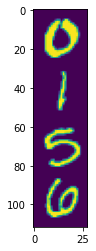

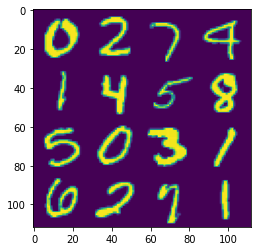

In [127]:
batch_size = 16
sample_idx = np.random.randint(0, x_train.shape[0], batch_size)
G = int(batch_size**0.5)
sample = x_train[sample_idx]
print(sample.shape)
print(np.concatenate(sample.reshape(G, 28*G, 28), axis=1).shape) # 第一個G是number, axis=1是28
plt.figure(1)
plt.imshow(sample.reshape(G, 28*G, 28)[0]) # 4 * 112 * 28
plt.figure(2)
plt.imshow(np.concatenate(sample.reshape(G, 28*G, 28), axis=1))

In [128]:
import numpy as np
# === Kai <3 === #
def softmax(x, d=False):
    # Numerically stable with large exponentials
    # x.shape : (16, 10)
    exps = np.exp(x - np.max(x, axis=1).reshape(-1,1)) # substract biggest value for each row
    # exps.shape : (16, 10)
    if d:
        return (exps / np.sum(exps, axis=1).reshape(-1, 1) ) * (1 - exps / np.sum(exps, axis=1).reshape(-1, 1))
    return (exps / np.sum(exps, axis=1).reshape(-1, 1))

def sigmoid(x, d=False):
    if d:
        return sigmoid(x) * (1 - sigmoid(x))
    else:
        y = np.zeros(x.shape)    
        y[x <= 0] = np.exp(x[x<=0]) / (1 + np.exp(x[x<=0]))
        y[x > 0] = 1 / (1 + np.exp(-x[x > 0]))
        return y

def one_hot(y:list):
    return np.eye(10)[y]

In [129]:
784*32 + 32*10

25408

In [130]:
from tqdm import trange
# === neural network === #
np.random.seed(5)
hidden = 128
weights_0 = np.random.uniform(-1, 1, (784, hidden))
weights_1 = np.random.uniform(-1, 1, (hidden, 10))

# === training === #
batch_size = 16
lr = 0.001
total_step = 10000
error = []
accs = []
test_accs = []
for i in (t := trange(total_step)):
    sample_idx = np.random.randint(0, x_train.shape[0], batch_size)
    batch_x, batch_y = x_train[sample_idx], y_train[sample_idx]
    batch_x = batch_x.reshape((batch_x.shape[0], -1))/255 # (16, 784)

    # === forward === #
    p1 = np.dot(batch_x, weights_0) # (16x784) X (784x500)
    act1 = sigmoid(p1)
    p2 = np.dot(act1, weights_1)    # (16x500) X (500x10)
    out = sigmoid(p2)
    
    y = one_hot(batch_y)
    acc = np.sum(batch_y == np.argmax(out,axis=1))/batch_size
    err = np.mean(np.sum((y - out) ** 2, axis=1))
    error.append(err)
    accs.append(acc)
    if i%100 ==0:
        t.set_description(f"Err : {err :.2f}, Acc : {acc :.2f}")
    # === backward === #
    t1 = 2 * (y - out) * sigmoid(p2, True) #(16, 10)
    t2 = np.dot(act1.T , t1) # (784, 10)

    t_1 = np.dot(weights_1, t1.T)
    t_2 = sigmoid(p1, True) * t_1.T
    t_3 = np.dot(batch_x.T, t_2)

    weights_0 = weights_0 + (lr * t_3)
    weights_1 = weights_1 + (lr * t2)
    
    # === testing === #
    test_idx = np.random.randint(0, x_test.shape[0], batch_size)
    test_x, test_y = x_test[test_idx], y_test[test_idx]
    test_x = test_x.reshape((test_x.shape[0], -1))/255 # (16, 784)
    p1 = np.dot(test_x, weights_0) # (16x784) X (784x500)
    act1 = sigmoid(p1)
    p2 = np.dot(act1, weights_1)    # (16x500) X (500x10)
    test_out = sigmoid(p2)
    acc = np.sum(test_y == np.argmax(test_out,axis=1))/batch_size
    test_accs.append(acc)

Err : 0.54, Acc : 0.62: 100%|██████████| 10000/10000 [00:18<00:00, 527.62it/s]


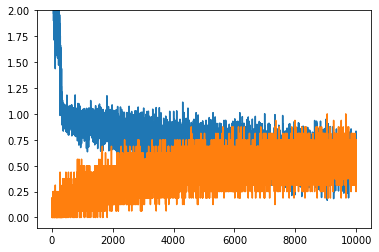

In [131]:
plt.ylim(-0.1, 2)
plt.plot(error)
plt.plot(accs)

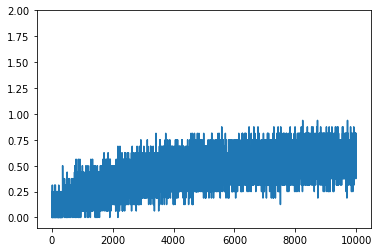

In [132]:
plt.ylim(-0.1, 2)
plt.plot(test_accs)